In [1]:
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
import scipy.io as sio
from scipy.io import savemat
from torch import optim
from torch.autograd import Variable
from vit_pytorch import ViT
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time
import os

In [2]:
import argparse
import collections
import math
import time

import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from torchsummary import summary
import geniter
import record
import Utils
import gc

In [3]:
PARAM_DATASET = 'KSC'  # UP,IN,SV, KSC
PARAM_EPOCH = 100
PARAM_ITER = 3
PATCH_SIZE = 6
PARAM_VAL = 0.95

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
seeds = [1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341]
#global Dataset  # UP,IN,SV, KSC
dataset = PARAM_DATASET  # input('Please input the name of Dataset(IN, UP, SV, KSC):')
Dataset = dataset.upper()

In [6]:
def load_dataset(Dataset, split=0.9):
    data_path = '../../data/'
    if Dataset == 'IN':
        mat_data = sio.loadmat(data_path + 'Indian_pines_corrected.mat')
        mat_gt = sio.loadmat(data_path + 'Indian_pines_gt.mat')
        data_hsi = mat_data['indian_pines_corrected']
        gt_hsi = mat_gt['indian_pines_gt']
        K = 200
        TOTAL_SIZE = 10249
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'UP':
        uPavia = sio.loadmat(data_path + 'PaviaU.mat')
        gt_uPavia = sio.loadmat(data_path + 'PaviaU_gt.mat')
        data_hsi = uPavia['paviaU']
        gt_hsi = gt_uPavia['paviaU_gt']
        K = 103
        TOTAL_SIZE = 42776
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'SV':
        SV = sio.loadmat(data_path + 'Salinas_corrected.mat')
        gt_SV = sio.loadmat(data_path + 'Salinas_gt.mat')
        data_hsi = SV['salinas_corrected']
        gt_hsi = gt_SV['salinas_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 54129
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

    if Dataset == 'KSC':
        KSV = sio.loadmat(data_path + 'KSC.mat')
        gt_KSV = sio.loadmat(data_path + 'KSC_gt.mat')
        data_hsi = KSV['KSC']
        gt_hsi = gt_KSV['KSC_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 5211
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)

        
    if Dataset == 'BO':
        BO = sio.loadmat(data_path + 'Botswana.mat')
        gt_BO = sio.loadmat(data_path + 'Botswana_gt.mat')
        data_hsi = BO['Botswana']
        gt_hsi = gt_BO['Botswana_gt']
        K = data_hsi.shape[2]
        TOTAL_SIZE = 3248
        VALIDATION_SPLIT = split
        TRAIN_SIZE = math.ceil(TOTAL_SIZE * VALIDATION_SPLIT)


    shapeor = data_hsi.shape
    data_hsi = data_hsi.reshape(-1, data_hsi.shape[-1])
    data_hsi = PCA(n_components=K).fit_transform(data_hsi)
    shapeor = np.array(shapeor)
    shapeor[-1] = K
    data_hsi = data_hsi.reshape(shapeor)

    return data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT

In [7]:
data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT = load_dataset(
    Dataset, PARAM_VAL)

In [8]:
image_x, image_y, BAND = data_hsi.shape

In [9]:
data = data_hsi.reshape(
    np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
data.shape

(314368, 176)

In [10]:
gt_hsi.shape

(512, 614)

In [11]:
gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]), )
gt.shape
CLASSES_NUM = max(gt)

In [12]:
PATCH_LENGTH = PATCH_SIZE

In [13]:
img_rows = 2 * PATCH_LENGTH + 1
img_cols = 2 * PATCH_LENGTH + 1
img_channels = data_hsi.shape[2]
INPUT_DIMENSION = data_hsi.shape[2]
ALL_SIZE = data_hsi.shape[0] * data_hsi.shape[1]
VAL_SIZE = int(TRAIN_SIZE)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

In [14]:
data = preprocessing.scale(data)
data_ = data.reshape(data_hsi.shape[0], data_hsi.shape[1], data_hsi.shape[2])
whole_data = data_
padded_data = np.lib.pad(
    whole_data, ((PATCH_LENGTH, PATCH_LENGTH), (PATCH_LENGTH, PATCH_LENGTH),
                 (0, 0)),
    'constant',
    constant_values=0)

In [15]:
def sampling(proportion, ground_truth):
    train = {}
    test = {}
    labels_loc = {}
    m = max(ground_truth)
    for i in range(m):
        indexes = [
            j for j, x in enumerate(ground_truth.ravel().tolist())
            if x == i + 1
        ]
        np.random.shuffle(indexes)
        labels_loc[i] = indexes
        if proportion != 1:
            nb_val = max(int((1 - proportion) * len(indexes)), 3)
        else:
            nb_val = 0
        train[i] = indexes[:nb_val]
        test[i] = indexes[nb_val:]
    train_indexes = []
    test_indexes = []
    for i in range(m):
        train_indexes += train[i]
        test_indexes += test[i]
    np.random.shuffle(train_indexes)
    np.random.shuffle(test_indexes)
    return train_indexes, test_indexes

In [16]:
index_iter=0
np.random.seed(seeds[index_iter])
train_indices, test_indices = sampling(VALIDATION_SPLIT, gt)
_, total_indices = sampling(1, gt)

TRAIN_SIZE = len(train_indices)
#print('Train size: ', TRAIN_SIZE)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE
#print('Test size: ', TEST_SIZE)
VAL_SIZE = int(TRAIN_SIZE)
#print('Validation size: ', VAL_SIZE)

print('-----Selecting Small Pieces from the Original Cube Data-----')
x_train,y_train, x_val,y_val, x_test,y_test, all_data, gt_all = geniter.generate_iter(
        TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE,
        total_indices, VAL_SIZE, whole_data, PATCH_LENGTH, padded_data,
        INPUT_DIMENSION, 16, gt)  #batchsize in 1


-----Selecting Small Pieces from the Original Cube Data-----
Train size:  (156, 13, 13, 145)
Test size:  (2936, 13, 13, 145)
Validation size:  (156, 13, 13, 145)


In [17]:
band=x_train.shape[-1]
patch=x_train.shape[-2]

In [18]:
model = ViT(
    image_size = patch,
    image_band = band,
    num_classes = CLASSES_NUM,
    dim = 64,
    depth = 5,
    heads = 4,
    mlp_dim = 8,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = 'ADCF'
)

In [19]:
model = model.cuda()

In [20]:
summary(model, input_size=(patch,patch,band))

torch.Size([2, 146, 64])
5
torch.Size([2, 170, 64])
5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 145, 64]          10,880
           Dropout-2              [-1, 146, 64]               0
         LayerNorm-3              [-1, 146, 64]             128
            Linear-4             [-1, 146, 192]          12,288
            Linear-5              [-1, 146, 64]           4,160
           Dropout-6              [-1, 146, 64]               0
         Attention-7              [-1, 146, 64]               0
           PreNorm-8              [-1, 146, 64]               0
          Residual-9              [-1, 146, 64]               0
        LayerNorm-10              [-1, 146, 64]             128
           Linear-11               [-1, 146, 8]             520
             GELU-12               [-1, 146, 8]               0
          Dropout-13               [-1, 146, 8]  

In [16]:
def train(net,
          train_iter,
          valida_iter,
          loss,
          optimizer,
          device,
          epochs,
          early_stopping=True,
          early_num=20):
    loss_list = [100]
    early_epoch = 0

    net = net.to(device)
    print("training on ", device)
    start = time.time()
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    for epoch in range(epochs):
        train_acc_sum, n = 0.0, 0
        time_epoch = time.time()
        lr_adjust = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=PARAM_EPOCH//10, gamma=0.9)
        for X, y in train_iter:

            batch_count, train_l_sum = 0, 0
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y.long())

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        lr_adjust.step()
        valida_acc, valida_loss = record.evaluate_accuracy(
            valida_iter, net, loss, device)
        loss_list.append(valida_loss)

        train_loss_list.append(train_l_sum)  # / batch_count)
        train_acc_list.append(train_acc_sum / n)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

        print(
            'epoch %d, train loss %.6f, train acc %.3f, valida loss %.6f, valida acc %.3f, time %.1f sec'
            % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
               valida_loss, valida_acc, time.time() - time_epoch))

        PATH = "./net_DBA.pt"

        if early_stopping and loss_list[-2] < loss_list[-1]:
            if early_epoch == 0:
                torch.save(net.state_dict(), PATH)
            early_epoch += 1
            loss_list[-1] = loss_list[-2]
            if early_epoch == early_num:
                net.load_state_dict(torch.load(PATH))
                break
        else:
            early_epoch = 0

    print('epoch %d, loss %.4f, train acc %.3f, time %.1f sec'
          % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,
             time.time() - start))

In [17]:
loss = torch.nn.CrossEntropyLoss()

In [18]:
ITER = PARAM_ITER
KAPPA = []
OA = []
AA = []
TRAINING_TIME = []
TESTING_TIME = []
ELEMENT_ACC = np.zeros((ITER, CLASSES_NUM))

In [19]:
del data_hsi,data,data_
gc.collect()

0

In [20]:
for index_iter in range(ITER):
    print('iter:', index_iter)
    
    np.random.seed(seeds[index_iter])
    
    np.random.seed(seeds[index_iter])
    # train_indices, test_indices = select(gt)
    train_indices, test_indices = sampling(VALIDATION_SPLIT, gt)
    _, total_indices = sampling(1, gt)

    TRAIN_SIZE = len(train_indices)
    #print('Train size: ', TRAIN_SIZE)
    TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE
    #print('Test size: ', TEST_SIZE)
    VAL_SIZE = int(TRAIN_SIZE)
    #print('Validation size: ', VAL_SIZE)

    print('-----Selecting Small Pieces from the Original Cube Data-----')
    x_train,y_train, x_val,y_val, x_test,y_test, all_data, gt_all = geniter.generate_iter(
            TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE,
            total_indices, VAL_SIZE, whole_data, PATCH_LENGTH, padded_data,
            INPUT_DIMENSION, 16, gt)  #batchsize in 1

    del all_data,gt_all
    gc.collect()
    
    band=x_train.shape[-1]
    patch=x_train.shape[-2]
    
    
    x_train=torch.from_numpy(x_train).type(torch.FloatTensor) 
    y_train=torch.from_numpy(y_train).type(torch.FloatTensor) 
    Label_train=Data.TensorDataset(x_train,y_train)
    
    del x_train,y_train
    gc.collect()
    
    x_test=torch.from_numpy(x_test).type(torch.FloatTensor)
    y_test=torch.from_numpy(y_test).type(torch.FloatTensor) 
    Label_test=Data.TensorDataset(x_test,y_test)
    
    del x_test,y_test
    gc.collect()
    
    x_val=torch.from_numpy(x_val).type(torch.FloatTensor)
    y_val=torch.from_numpy(y_val).type(torch.FloatTensor)
    Label_val=Data.TensorDataset(x_val,y_val)
    
    del x_val,y_val
    gc.collect()
    
    
    label_train_loader=Data.DataLoader(Label_train,batch_size=64,shuffle=True)
    label_test_loader=Data.DataLoader(Label_test,batch_size=64,shuffle=False)
    label_val_loader=Data.DataLoader(Label_val,batch_size=64,shuffle=False)
    
    del Label_train,Label_test,Label_val
    gc.collect()
    
    model = ViT(
    image_size = patch,
    image_band = band,
    num_classes = CLASSES_NUM,
    dim = 64,
    depth = 5,
    heads = 4,
    mlp_dim = 8,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = 'ADCF'
    )
    model = model.cuda()
    model.train()
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=5e-4,
        weight_decay=0)

    
    tic1 = time.time()
    train(
            model,
            label_train_loader,
            label_val_loader,
            loss,
            optimizer,
            device,
            epochs=PARAM_EPOCH)
    toc1 = time.time()
    
    
    pred_test = []
    tic2 = time.time()
    with torch.no_grad():
        for X, y in label_test_loader:
            X = X.to(device)
            model.eval()
            y_hat = model(X)
            pred_test.extend(np.array(model(X).cpu().argmax(axis=1)))
    toc2 = time.time()
    collections.Counter(pred_test)
    gt_test = gt[test_indices] - 1

    overall_acc = metrics.accuracy_score(pred_test, gt_test[:-VAL_SIZE])
    confusion_matrix = metrics.confusion_matrix(pred_test, gt_test[:-VAL_SIZE])
    each_acc, average_acc = record.aa_and_each_accuracy(confusion_matrix)
    kappa = metrics.cohen_kappa_score(pred_test, gt_test[:-VAL_SIZE])
    
    torch.save(
        model.state_dict(), "./models/MyTransformerPatch_" + str(img_rows) + '_' +
        Dataset + '_split_' + str(VALIDATION_SPLIT) + str(round(overall_acc, 3)) + '.pt')
    KAPPA.append(kappa)
    OA.append(overall_acc)
    AA.append(average_acc)
    TRAINING_TIME.append(toc1 - tic1)
    TESTING_TIME.append(toc2 - tic2)
    ELEMENT_ACC[index_iter, :] = each_acc
    
    del label_train_loader,label_test_loader,label_val_loader
    gc.collect()
    
print("--------" + " Training Finished-----------")
record.record_output(
    OA, AA, KAPPA, ELEMENT_ACC, TRAINING_TIME, TESTING_TIME,
    './report/' + 'MyTransformerPatch_' + str(img_rows) + '_' + Dataset + 'split'
    + str(VALIDATION_SPLIT) +'.txt')


iter: 0
-----Selecting Small Pieces from the Original Cube Data-----
Train size:  (156, 13, 13, 145)
Test size:  (2936, 13, 13, 145)
Validation size:  (156, 13, 13, 145)
training on  cuda
epoch 1, train loss 2.745400, train acc 0.071, valida loss 2.539768, valida acc 0.115, time 5.1 sec
epoch 2, train loss 2.446501, train acc 0.154, valida loss 2.255063, valida acc 0.224, time 0.2 sec
epoch 3, train loss 2.153551, train acc 0.359, valida loss 2.108610, valida acc 0.372, time 0.2 sec
epoch 4, train loss 2.108338, train acc 0.506, valida loss 1.921215, valida acc 0.462, time 0.2 sec
epoch 5, train loss 1.668115, train acc 0.647, valida loss 1.667006, valida acc 0.545, time 0.2 sec
epoch 6, train loss 1.550220, train acc 0.763, valida loss 1.412457, valida acc 0.667, time 0.2 sec
epoch 7, train loss 1.058279, train acc 0.885, valida loss 1.163644, valida acc 0.769, time 0.2 sec
epoch 8, train loss 0.981452, train acc 0.897, valida loss 0.958120, valida acc 0.840, time 0.2 sec
epoch 9, tra

epoch 81, train loss 0.008117, train acc 1.000, valida loss 0.025347, valida acc 0.962, time 0.2 sec
epoch 82, train loss 0.007487, train acc 1.000, valida loss 0.024856, valida acc 0.962, time 0.2 sec
epoch 83, train loss 0.006951, train acc 1.000, valida loss 0.024612, valida acc 0.962, time 0.2 sec
epoch 84, train loss 0.006363, train acc 1.000, valida loss 0.024605, valida acc 0.962, time 0.2 sec
epoch 85, train loss 0.007008, train acc 1.000, valida loss 0.024377, valida acc 0.962, time 0.2 sec
epoch 86, train loss 0.007004, train acc 1.000, valida loss 0.023911, valida acc 0.962, time 0.2 sec
epoch 87, train loss 0.006198, train acc 1.000, valida loss 0.023533, valida acc 0.962, time 0.2 sec
epoch 88, train loss 0.007020, train acc 1.000, valida loss 0.023031, valida acc 0.962, time 0.2 sec
epoch 89, train loss 0.006233, train acc 1.000, valida loss 0.022464, valida acc 0.962, time 0.2 sec
epoch 90, train loss 0.006509, train acc 1.000, valida loss 0.021973, valida acc 0.962, tim

epoch 60, train loss 0.013283, train acc 1.000, valida loss 0.248565, valida acc 0.974, time 0.2 sec
epoch 61, train loss 0.012887, train acc 1.000, valida loss 0.248476, valida acc 0.974, time 0.2 sec
epoch 62, train loss 0.013007, train acc 1.000, valida loss 0.248582, valida acc 0.974, time 0.2 sec
epoch 63, train loss 0.011158, train acc 1.000, valida loss 0.247742, valida acc 0.974, time 0.2 sec
epoch 64, train loss 0.012305, train acc 1.000, valida loss 0.245695, valida acc 0.974, time 0.2 sec
epoch 65, train loss 0.010785, train acc 1.000, valida loss 0.243887, valida acc 0.974, time 0.2 sec
epoch 66, train loss 0.010974, train acc 1.000, valida loss 0.242969, valida acc 0.974, time 0.2 sec
epoch 67, train loss 0.010325, train acc 1.000, valida loss 0.242840, valida acc 0.974, time 0.2 sec
epoch 68, train loss 0.011879, train acc 1.000, valida loss 0.242619, valida acc 0.974, time 0.2 sec
epoch 69, train loss 0.010038, train acc 1.000, valida loss 0.243636, valida acc 0.974, tim

epoch 39, train loss 0.022953, train acc 1.000, valida loss 0.058985, valida acc 1.000, time 0.2 sec
epoch 40, train loss 0.023050, train acc 1.000, valida loss 0.055955, valida acc 1.000, time 0.2 sec
epoch 41, train loss 0.022965, train acc 1.000, valida loss 0.053283, valida acc 1.000, time 0.2 sec
epoch 42, train loss 0.025926, train acc 1.000, valida loss 0.051384, valida acc 1.000, time 0.2 sec
epoch 43, train loss 0.019789, train acc 1.000, valida loss 0.049333, valida acc 1.000, time 0.2 sec
epoch 44, train loss 0.020970, train acc 1.000, valida loss 0.047793, valida acc 1.000, time 0.2 sec
epoch 45, train loss 0.019963, train acc 1.000, valida loss 0.046288, valida acc 1.000, time 0.2 sec
epoch 46, train loss 0.018021, train acc 1.000, valida loss 0.044757, valida acc 1.000, time 0.2 sec
epoch 47, train loss 0.018296, train acc 1.000, valida loss 0.042912, valida acc 1.000, time 0.2 sec
epoch 48, train loss 0.018538, train acc 1.000, valida loss 0.041219, valida acc 1.000, tim

In [21]:
x_train,y_train, x_val,y_val, x_test,y_test, all_data, gt_all = geniter.generate_iter(
            TRAIN_SIZE, train_indices, TEST_SIZE, test_indices, TOTAL_SIZE,
            total_indices, VAL_SIZE, whole_data, PATCH_LENGTH, padded_data,
            INPUT_DIMENSION, 16, gt)  #batchsize in 1

Train size:  (156, 13, 13, 145)
Test size:  (2936, 13, 13, 145)
Validation size:  (156, 13, 13, 145)


In [22]:
del whole_data,padded_data,x_train,y_train, x_val,y_val, x_test,y_test
gc.collect()

0

In [23]:
x_all=torch.from_numpy(all_data).type(torch.FloatTensor)
y_all=torch.from_numpy(gt_all).type(torch.FloatTensor)
Label_all=Data.TensorDataset(x_all,y_all)

In [24]:
del x_all,y_all
gc.collect()

0

In [25]:
label_all_loader=Data.DataLoader(Label_all,batch_size=64,shuffle=False)

------Get classification maps successful-------


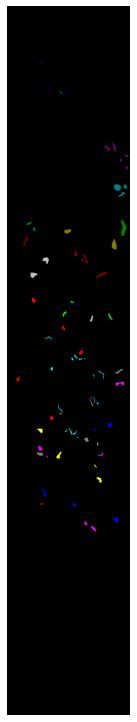

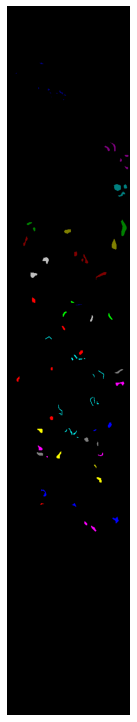

In [26]:
Utils.generate_png(
    label_all_loader, model, gt_hsi, Dataset, device, total_indices,
    './classification_maps/' + 'MyTransformerPatch_' + str(img_rows) + '_' +
    Dataset + 'split' + str(VALIDATION_SPLIT))